# Deep Learning for Computer Vision:  Assignment 2


## Computer Science: COMS W 4995 004


## Due: February 27, 2018

#### Problem

You are given the noisy XOR data generated for you below. Your task is to implement a multi-layer perceptron binary classifier with one hidden layer. For the activiation function of the hidden units use ReLu or leaky ReLu. For the loss function use a softplus on a linear output layer as we did in class.

a) Implement each layer of the network as a separate function with both forward propagation and backpropagation. 

b) Train the network using stochastic gradient descent with mini-batches.  

c) Show the decision regions of the trained classifier by densely generating points in the plane and color coding these points with the binary labels. 

d) Repeat (b) and (c) varying the number of hidden units: 3, 16, 512. Discuss how the number of hidden units effects the solution.

e) Try choosing you own loss function (without asking me or the TAs what you should choose), repeating (d).

f) Now try with three inputs, generating your own training and validation data. (For this XOR the output should be a 1 if and only if exactly one of the inputs is 1. But make the training data noisey as before.) Use softplus loss. Do not try to show the decision regions, instead generate a validation set in the same manner as the training set, classify the samples, and compute the classification accuracy.

If you are struggling to get the network to converge, experiment with different learning rates.

Grading: a-d = 85%, e=10%, f=5%. 

#### NOTE:  Do not to use keras, tensorflow, pytorch, sklearn, etc. to do this.  You must build the machine learning components from scratch.



Let's start by importing some libraries.

In [1]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

Let's make up some noisy XOR data.

In [2]:
data = pd.DataFrame(np.zeros((5000, 3)), columns=['x1', 'x2', 'y'])

# Let's make up some noisy XOR data to use to build our binary classifier
for i in range(len(data.index)):
    x1 = 1.0 * random.randint(0,1)
    x2 = 1.0 * random.randint(0,1)
    y = 1.0 * np.logical_xor(x1==1,x2==1)
    x1 = x1 + 0.15 * np.random.normal()
    x2 = x2 + 0.15 * np.random.normal()
    data.iloc[i,0] = x1
    data.iloc[i,1] = x2
    data.iloc[i,2] = y
        
data.head()

,x1,x2,y
0,1.045407,0.773056,0.0
1,-0.100313,-0.085353,0.0
2,-0.098628,1.046284,1.0
3,1.046030,-0.170376,1.0
4,0.276545,-0.041373,0.0


Let's message this data into a numpy format.

In [3]:
# set X (training data) and y (target variable)
cols = data.shape[1]
X = data.iloc[:,0:cols-1]
y = data.iloc[:,cols-1:cols]

# The cost function is expecting numpy matrices so we need to convert X and y before we can use them.  
X = np.matrix(X.values)
y = np.matrix(y.values)

Let's make a sloppy plotting function for our binary data.

In [4]:
# Sloppy function for plotting our data
def plot_data(X, y_prob):
    
    fig, ax = plt.subplots(figsize=(12,8))
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

    y_predict = y_prob > 0.5
    indices_0 = [k for k in range(0, X.shape[0]) if not y_predict[k]]
    indices_1 = [k for k in range(0, X.shape[0]) if y_predict[k]]

    ax.plot(X[indices_0, 0], X[indices_0,1], marker='o', linestyle='', ms=5, label='0')
    ax.plot(X[indices_1, 0], X[indices_1,1], marker='o', linestyle='', ms=5, label='1')

    ax.legend()
    ax.legend(loc=2)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_title('Noisy XOR')
    plt.show()

Now let's plot it.

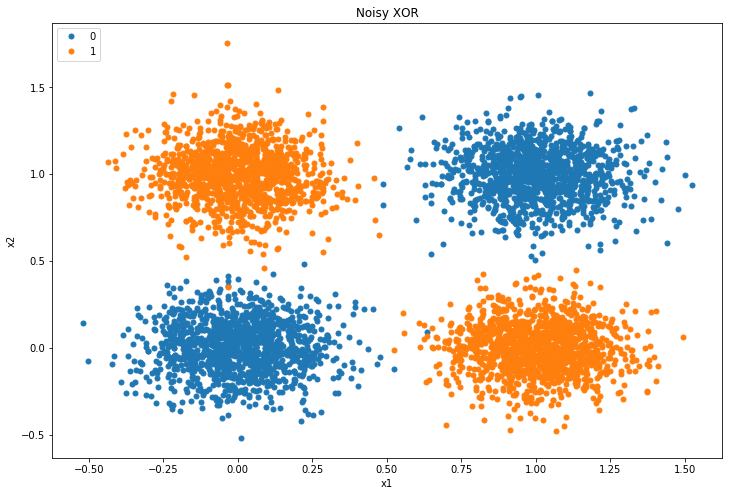

In [5]:
plot_data(X, y)

Now let's create functions for forward and backward prop through the layers and we are off...

- Note I combine u1 and u2 on slides lecture_6 into u1,    u3 and u4 on slides into u2. 
- This is because in standard neural network implementation, they are implemented as affine layer, this made my network simpler to code.
- Reference: cs231n

In [6]:
def input_affine_forward(X, w1, b1):
    u1 = X * w1.T + b1.reshape(-1)
    return u1

def input_activation_forward(u1):
    h = np.maximum(0, u1)
    return h

def output_affine_forward(h, w2, b2, y):
    z = h * w2.T + b2.reshape(-1)
    u2 = np.multiply((1 - 2*y), z)
    return u2
    
def softplus(u2):
    return np.log(1 + np.exp(u2))

In [7]:
"""
shape 
W (dim_i, dim_i-1)
X (n_sample, n_feature)
"""
def softplus_backward(u2):
    du2 = 1/(1+np.exp(-u2))
    return du2

def output_affine_backward(du2, h, w2, y):
    dZ = np.multiply(du2, (1-2*y))
    dW2 = dZ.T * h
    db2 = dZ 
    dh = dZ * w2
    return dW2, db2, dh

def input_activation_backward(u1, dh):
    h_cache = np.maximum(0, u1)
    h_cache[h_cache > 0] = 1
    du1 = np.multiply(h_cache, dh)
    return du1

def input_affine_backward(du1, X):
    dW1 = du1.T * X
    db1 = du1
    return dW1, db1

In [8]:
def forward_propagation(X, w, b, y):
    u1 = input_affine_forward(X, w[1], b[1])
    h = input_activation_forward(u1)
    u2 = output_affine_forward(h, w[2], b[2], y)
    loss = softplus(u2)
    return u1, h, u2, loss

def back_propagation(u2, u1, X, h, w, y):
    du2 = softplus_backward(u2)
    dW2, db2, dh = output_affine_backward(du2, h, w[2], y)
    du1 = input_activation_backward(u1, dh)
    dW1, db1 = input_affine_backward(du1, X)
    return dW2, db2, dW1, db1

In [9]:
def train(X, y, in_dim = 2, h_dim = 3, batch_size = 16, max_iter = 300, eta = 0.01):
    w = {}
    b = {}
#     my own generation
    w[1] = np.matrix(np.random.random((h_dim, in_dim)) - 0.5)
    w[2] = np.matrix(np.random.random((1, h_dim)) - 0.5)
    b[1] = np.matrix(0.1 * np.random.random([h_dim, 1]))
    b[2] = np.matrix(0.1 * np.random.random([1, 1]))
#     based on cs231n
#     w[1] = np.matrix(np.random.randn(h_dim, in_dim) / np.sqrt(in_dim))
#     w[2] = np.matrix(np.random.randn(1, h_dim) / np.sqrt(h_dim))
#     b[1] = np.matrix(np.zeros([h_dim, 1]))
#     b[2] = np.matrix(np.zeros([1, 1]))
    
    # batch generalization with replacement
#     def get_batch(batch_size = 16):
#         idx = np.random.randint(X.shape[0], size = batch_size)
#         X_batch, y_batch = X[idx, :], y[idx]
#         return X_batch, y_batch

    # batch generalization without replacement
    def get_batch(batch_size = 16):
        indicies = np.arange(X.shape[0])
        for i in range(int(np.ceil(X.shape[0] / batch_size))):
            start_idx = (i * batch_size) % X.shape[0]
            idx = indicies[start_idx:start_idx + batch_size]
            yield X[idx, :], y[idx]
    
    for i in range(max_iter):
        for X_batch, y_batch in get_batch():
#             X_batch, y_batch = get_batch()
            u1, h, u2, loss = forward_propagation(X_batch, w, b, y_batch)
            dW2, db2, dW1, db1 = back_propagation(u2, u1, X_batch, h, w, y_batch)

            w[1] -= 1.0/batch_size * eta * dW1
            w[2] -= 1.0/batch_size * eta * dW2
            b[1] -= 1.0/batch_size * eta * (np.sum(db1, axis = 0).reshape(h_dim,1))
            b[2] -= 1.0/batch_size * eta * (np.sum(db2, axis = 0).reshape(1,1))
            
    return w, b    

In [10]:
def predict(X_test, w, b):
    u1 = input_affine_forward(X_test, w[1], b[1])
    h = input_activation_forward(u1)
    u2 = h * w[2].T + b[2].reshape(-1)
    return 1/(1+np.exp(-u2))

In [11]:
def plot(X_test, w, b):
    X_test = np.matrix(np.random.uniform(-0.5, 1.5, (10000,2)))
    y_pred = predict(X_test, w, b)
    X_test0 = X_test[np.where(y_pred < 0.5)[0]]
    X_test1 = X_test[np.where(y_pred > 0.5)[0]]
    fig, ax = plt.subplots(figsize=(12,8))
    ax.plot(np.array(X_test0)[:,0],np.array(X_test0)[:,1], 'o', label='0')
    ax.plot(X_test1[:,0],X_test1[:,1], 'o', label='1')
    ax.legend()
    ax.legend(loc=2)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_title('decision region')
    plt.show()

d) Discuss how the number of hidden units effects the solution.
- We can see when we add the number of hidden units in the hidden layer, the classfication boundary becomes better in classifying the points (from slides: more hidden units was better at carving up the crossing hourglass shape of the data.). As it's stated in the universal approximation theorem, if we have enough hidden units, we can approximate “any” function!
- However, the training time increases when we increase the number of hidden units, more hidden units means harder to train (more time to converge).
- To overcome this problem, we can use deeper network, as stated in the slides,  [Montufar et al. 2014] showed that deeper networks are more efficient in that a deep rectified net can represent functions that would require an exponential number of hidden units in a shallow one hidden layer network

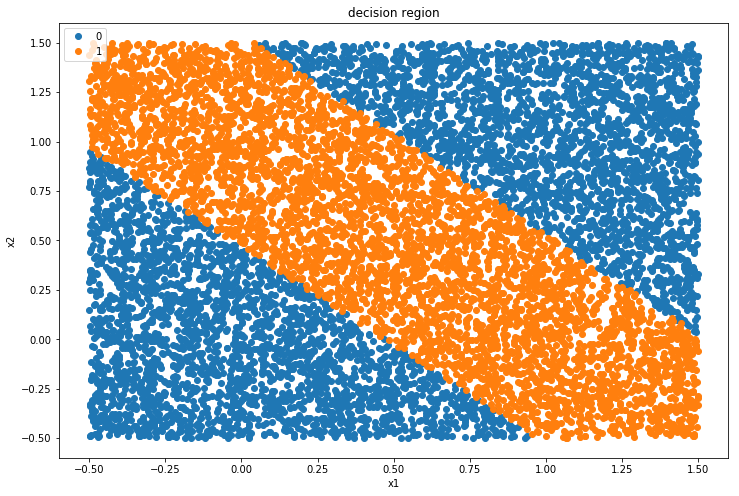

In [12]:
w, b = train(X,y)
X_test = np.matrix(np.random.uniform(-0.5, 1.5, (1000,2)))
plot(X_test, w, b)

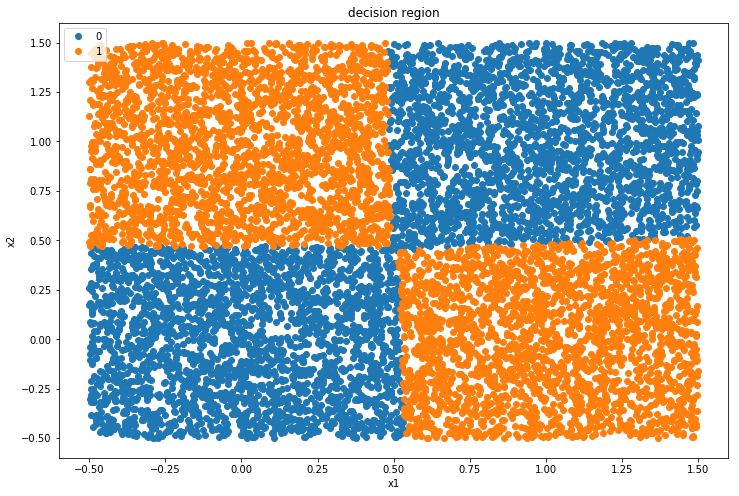

In [13]:
w, b = train(X,y,h_dim=16)
X_test = np.matrix(np.random.uniform(-0.5, 1.5, (10000,2)))
plot(X_test, w, b)

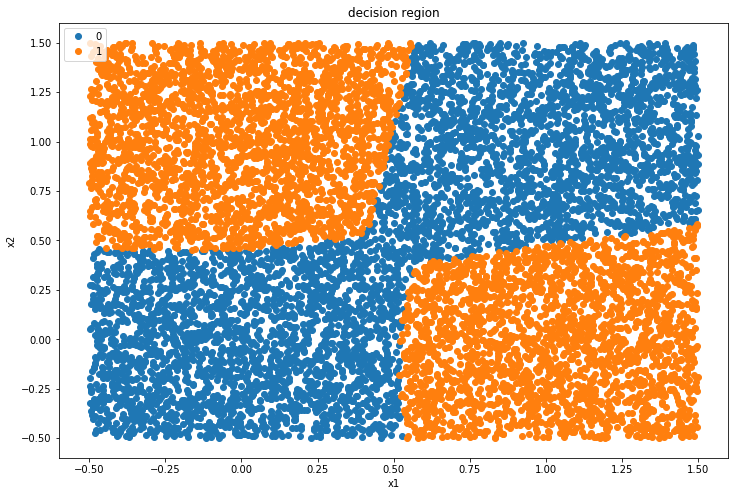

In [14]:
w, b = train(X,y,h_dim=512)
X_test = np.matrix(np.random.uniform(-0.5, 1.5, (10000,2)))
plot(X_test, w, b)

e)  In this part, I try two loss function, cross entropy loss and mse <br>
- use cross entropy loss function
$$J(z)=−\sum_{i}(y^{(i)}log(\sigma(z))+(1−y^{(i)})log(1−\sigma(z)))$$

In [15]:
# change the affine forward function 
# without (1-2y) * z modification
def ce_output_affine_forward(h, w2, b2):
    z = h * w2.T + b2.reshape(-1)
    return z
    
def cross_entropy_loss(z, y):
#     n = y.shape[0], TODO
    prob = 1/(1 + np.exp(-z))
    loss = - np.sum(np.multiply(y, np.log(prob)) + 
                    np.multiply((1-y), np.log(1-prob)))
    dprob = - (y/prob - (1-y)/(1-prob))
    dz = np.multiply(np.multiply(prob, 1-prob), dprob)
    return prob, loss, dz
    
# redefine output backward since without 
# (1-2y) * z modification
def ce_output_affine_backward(dZ, h, w2):
    dW2 = dZ.T * h
    db2 = dZ 
    dh = dZ * w2
    return dW2, db2, dh

In [16]:
# modify the forward and backward propagation with new loss function
def ceforward_propagation(X, w, b, y):
    u1 = input_affine_forward(X, w[1], b[1])
    h = input_activation_forward(u1)
    z = ce_output_affine_forward(h, w[2], b[2])
    prob, loss, dz = cross_entropy_loss(z, y)
    return u1, h, z, prob, loss, dz

def ceback_propagation(dz, u1, X, h, w):
    dW2, db2, dh = ce_output_affine_backward(dz, h, w[2])
    du1 = input_activation_backward(u1, dh)
    dW1, db1 = input_affine_backward(du1, X)
    return dW2, db2, dW1, db1

In [19]:
def ce_train(X, y, in_dim = 2, h_dim = 3, batch_size = 16, max_iter = 300, eta = 0.01):
    w = {}
    b = {}
#     my own generation
    w[1] = np.matrix(np.random.random((h_dim, in_dim)) - 0.5)
    w[2] = np.matrix(np.random.random((1, h_dim)) - 0.5)
    b[1] = np.matrix(0.1 * np.random.random([h_dim, 1]))
    b[2] = np.matrix(0.1 * np.random.random([1, 1]))

#     based on cs231n
#     w[1] = np.matrix(np.random.randn(h_dim, in_dim) / np.sqrt(in_dim))
#     w[2] = np.matrix(np.random.randn(1, h_dim) / np.sqrt(h_dim))
#     b[1] = np.matrix(np.zeros([h_dim, 1]))
#     b[2] = np.matrix(np.zeros([1, 1]))
    
    
#     # batch generalization with replacement
#     def get_batch(batch_size = 16):
#         idx = np.random.randint(X.shape[0], size = batch_size)
#         X_batch, y_batch = X[idx, :], y[idx]
#         return X_batch, y_batch

    # batch generalization without replacement
    def get_batch(batch_size = 16):
        indicies = np.arange(X.shape[0])
        for i in range(int(np.ceil(X.shape[0] / batch_size))):
            start_idx = (i * batch_size) % X.shape[0]
            idx = indicies[start_idx:start_idx + batch_size]
            yield X[idx, :], y[idx]
        
    for i in range(max_iter):
        for X_batch, y_batch in get_batch():
        #         X_batch, y_batch = get_batch()
            u1, h, z, prob, loss, dz = ceforward_propagation(X_batch,w,b,y_batch)
            dW2, db2, dW1, db1 = ceback_propagation(dz, u1, X_batch, h, w)

            w[1] -= 1.0/batch_size * eta * dW1
            w[2] -= 1.0/batch_size * eta * dW2
            b[1] -= 1.0/batch_size * eta * (np.sum(db1, axis = 0).reshape(h_dim,1))
            b[2] -= 1.0/batch_size * eta * (np.sum(db2, axis = 0).reshape(1,1))
    
    return w, b    

Discuss how the number of hidden units effects the solution.
- we can see when we add hidden units, the classfication boundary becomes better in classifying the points.(from slides: more hidden units was better at carving up the crossing hourglass shape of the data.). As it's stated in the universal approximation theorem, if we have enough hidden units we can approximate “any” function!
- However, the training time increases when we increase the number of hidden units, more hidden units means harder to train(more time to converge).
- To overcome this problem, we can use deeper network, as stated in the slides,  [Montufar et al. 2014] showed that deeper networks are more efficient in that a deep rectified net can represent functions that would require an exponential number of hidden units in a shallow one hidden layer network

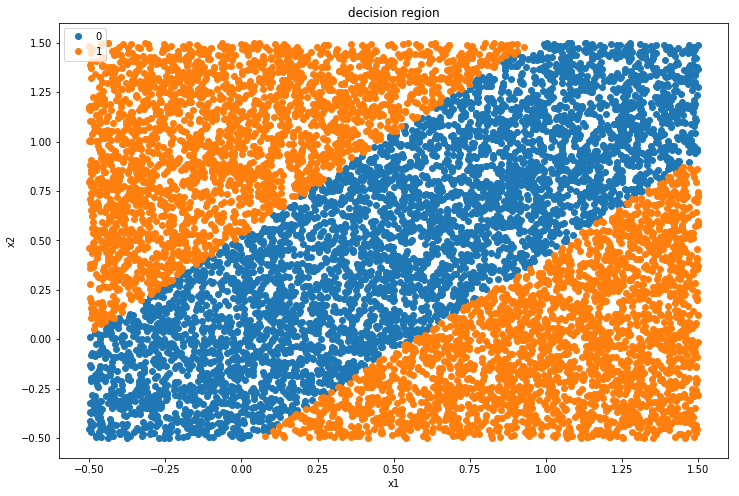

In [21]:
# cross_entropy_loss
# dim = 3
w, b = ce_train(X, y)
X_test = np.matrix(np.random.uniform(-0.5, 1.5, (10000,2)))
plot(X_test, w, b)

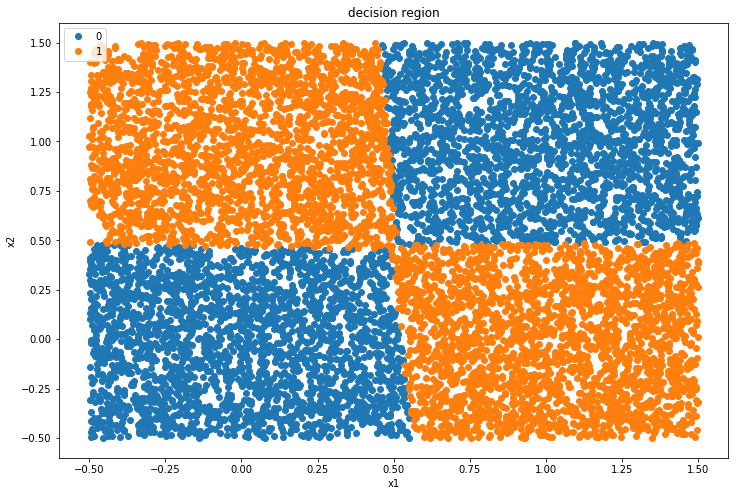

In [22]:
# cross_entropy_loss
# dim = 16
w, b = ce_train(X, y, h_dim = 16)
X_test = np.matrix(np.random.uniform(-0.5, 1.5, (10000,2)))
plot(X_test, w, b)

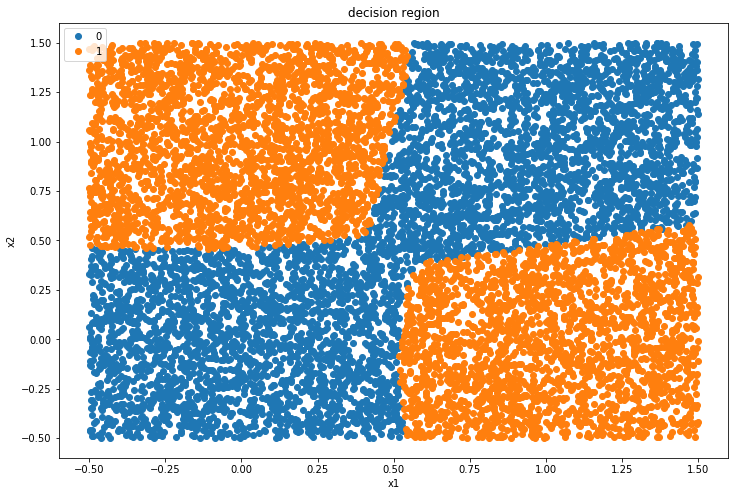

In [23]:
# cross_entropy_loss
# dim = 512
w, b = ce_train(X, y, h_dim = 512)
X_test = np.matrix(np.random.uniform(-0.5, 1.5, (10000,2)))
plot(X_test, w, b)

- use mse loss function
$$J(z)=\frac{1}{2}\sum_{i}(\sigma(z) - y^{(i)}) ^ 2$$

In [24]:
# change the affine forward function 
# without (1-2y) * z modification
def mse_output_affine_forward(h, w2, b2):
    z = h * w2.T + b2.reshape(-1)
    return z
    
def mse_loss(z, y):
    prob = 1/(1 + np.exp(-z))
    loss = np.sum(np.multiply((y - prob), (y - prob)))
    dprob = prob - y
    dz = np.multiply(np.multiply(prob, 1-prob), dprob)
    return prob, loss, dz
    
# redefine output backward since without 
# (1-2y) * z modification
def mse_output_affine_backward(dZ, h, w2):
    dW2 = dZ.T * h
    db2 = dZ 
    dh = dZ * w2
    return dW2, db2, dh

# modify the forward and backward propagation with new loss function
def mseforward_propagation(X, w, b, y):
    u1 = input_affine_forward(X, w[1], b[1])
    h = input_activation_forward(u1)
    z = mse_output_affine_forward(h, w[2], b[2])
    prob, loss, dz = mse_loss(z, y)
    return u1, h, z, prob, loss, dz

def mseback_propagation(dz, u1, X, h, w):
    dW2, db2, dh = mse_output_affine_backward(dz, h, w[2])
    du1 = input_activation_backward(u1, dh)
    dW1, db1 = input_affine_backward(du1, X)
    return dW2, db2, dW1, db1

In [25]:
def mse_train(X, y, in_dim = 2, h_dim = 3, batch_size = 16, max_iter = 300, eta = 0.01):
    w = {}
    b = {}
#     my own generation
    w[1] = np.matrix(np.random.random((h_dim, in_dim)) - 0.5)
    w[2] = np.matrix(np.random.random((1, h_dim)) - 0.5)
    b[1] = np.matrix(0.1 * np.random.random([h_dim, 1]))
    b[2] = np.matrix(0.1 * np.random.random([1, 1]))

#     based on cs231n
#     w[1] = np.matrix(np.random.randn(h_dim, in_dim) / np.sqrt(in_dim))
#     w[2] = np.matrix(np.random.randn(1, h_dim) / np.sqrt(h_dim))
#     b[1] = np.matrix(np.zeros([h_dim, 1]))
#     b[2] = np.matrix(np.zeros([1, 1]))
    
    
#     # batch generalization with replacement
#     def get_batch(batch_size = 16):
#         idx = np.random.randint(X.shape[0], size = batch_size)
#         X_batch, y_batch = X[idx, :], y[idx]
#         return X_batch, y_batch

    # batch generalization without replacement
    def get_batch(batch_size = 16):
        indicies = np.arange(X.shape[0])
        for i in range(int(np.ceil(X.shape[0] / batch_size))):
            start_idx = (i * batch_size) % X.shape[0]
            idx = indicies[start_idx:start_idx + batch_size]
            yield X[idx, :], y[idx]
        
    for i in range(max_iter):
        for X_batch, y_batch in get_batch():
        #         X_batch, y_batch = get_batch()
            u1, h, z, prob, loss, dz = mseforward_propagation(X_batch,w,b,y_batch)
            dW2, db2, dW1, db1 = mseback_propagation(dz, u1, X_batch, h, w)

            w[1] -= 1.0/batch_size * eta * dW1
            w[2] -= 1.0/batch_size * eta * dW2
            b[1] -= 1.0/batch_size * eta * (np.sum(db1, axis = 0).reshape(h_dim,1))
            b[2] -= 1.0/batch_size * eta * (np.sum(db2, axis = 0).reshape(1,1))
    
    return w, b    

Discuss how the number of hidden units effects the solution.
- we can see when we add hidden units, the classfication boundary becomes better in classifying the points(from slides: more hidden units was better at carving up the crossing hourglass shape of the data.). As it's stated in the universal approximation theorem, if we have enough hidden units we can approximate “any” function!
- However, the training time increases when we increase the number of hidden units, more hidden units means harder to train(more time to converge).
- To overcome this problem, we can use deeper network, as stated in the slides,  [Montufar et al. 2014] showed that deeper networks are more efficient in that a deep rectified net can represent functions that would require an exponential number of hidden units in a shallow one hidden layer network

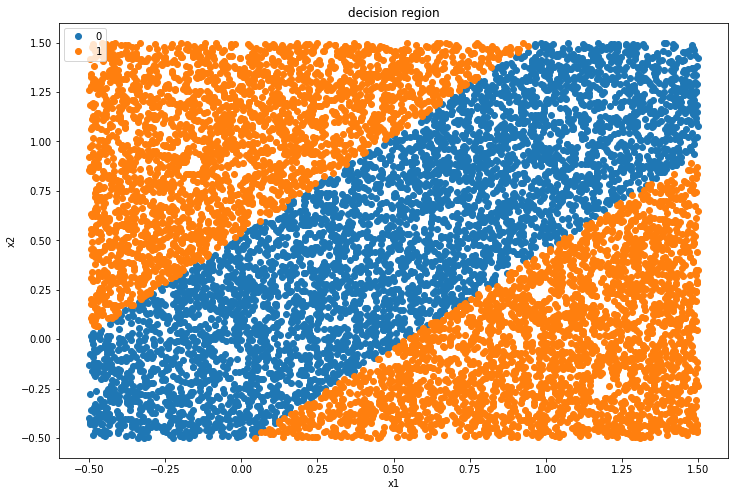

In [27]:
# mse loss
# dim = 3
w, b = mse_train(X, y, h_dim = 3)
X_test = np.matrix(np.random.uniform(-0.5, 1.5, (10000,2)))
plot(X_test, w, b)

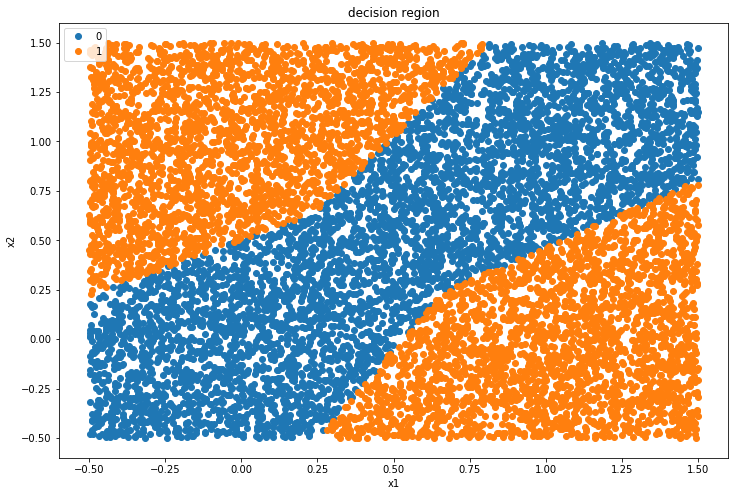

In [28]:
w, b = mse_train(X, y, h_dim = 16)
X_test = np.matrix(np.random.uniform(-0.5, 1.5, (10000,2)))
plot(X_test, w, b)

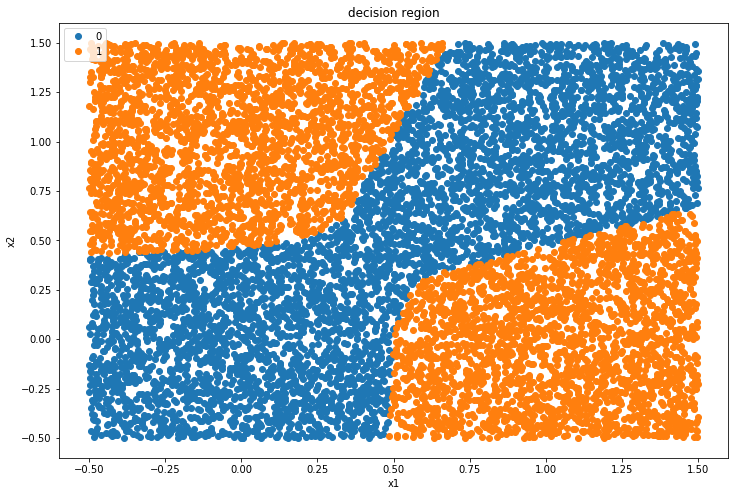

In [29]:
w, b = mse_train(X, y, h_dim = 512)
X_test = np.matrix(np.random.uniform(-0.5, 1.5, (10000,2)))
plot(X_test, w, b)

f) result with three inputs

In [30]:
# Reference: modify the code generating 2D input to generate 3D input
data = pd.DataFrame(np.zeros((10000, 4)), columns=['x1', 'x2', 'x3', 'y'])

# Let's make up some noisy XOR data to use to build our binary classifier
for i in range(len(data.index)):
    x1 = 1.0 * random.randint(0,1)
    x2 = 1.0 * random.randint(0,1)
    x3 = 1.0 * random.randint(0,1)
    y = 1.0 if x1 == 1 and x2 == 0 and x3 == 0 \
            or x1 == 0 and x2 == 1 and x3 == 0 \
            or x1 == 0 and x2 == 0 and x3 == 1 \
            else 0
    x1 = x1 + 0.15 * np.random.normal()
    x2 = x2 + 0.15 * np.random.normal()
    x3 = x3 + 0.15 * np.random.normal()
    data.iloc[i,0] = x1
    data.iloc[i,1] = x2
    data.iloc[i,2] = x3    
    data.iloc[i,3] = y
        
data.head()

,x1,x2,x3,y
0,0.992034,0.923278,-0.152197,0.0
1,0.918185,0.860031,1.058074,0.0
2,-0.202566,0.772477,0.918893,0.0
3,0.860366,0.787559,0.007564,0.0
4,0.742270,0.893176,-0.180558,0.0


In [31]:
# set X (training data) and y (target variable)
cols = data.shape[1]
X = data.iloc[:,0:cols-1]
y = data.iloc[:,cols-1:cols]

# The cost function is expecting numpy matrices so we need to convert X and y before we can use them.  
X = np.matrix(X.values)
y = np.matrix(y.values)

In [32]:
def train_val_split(X, y, val_size = 0.2):
    N = X.shape[0]
    train_size = int((1 - val_size) * N)
    X_train = X[:train_size,]
    y_train = y[:train_size,]
    X_val = X[train_size:,]
    y_val = y[train_size:,]
    return X_train, y_train, X_val, y_val

In [33]:
def get_accurancy(w, b, X_val, y_val):
    N = y_val.shape[0]
    y_prob = np.array(predict(X_val, w, b)).reshape(-1)
    y_predict = np.zeros(N)
    y_predict[y_prob > 0.5] = 1
    # since np.matrix can't reshape to vector
    # change back to np.array
    y_val = np.array(y_val).reshape(-1)
    return np.sum(y_predict == y_val) / N

In [34]:
X_train, y_train, X_val, y_val = train_val_split(X, y)

In [35]:
w, b = train(X_train, y_train, in_dim = 3, h_dim = 16)
val_acc = get_accurancy(w, b, X_val, y_val)
print("validation accurancy is %f" % val_acc)

validation accurancy is 0.994500
